In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/ .kaggle

In [ ]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [ ]:
!chmod 600 ~/ .kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d humansintheloop/teeth-segmentation-on-dental-x-ray-images

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images
License(s): CC0-1.0
100% 4.14G/4.14G [00:21<00:00, 257MB/s]
100% 4.14G/4.14G [00:21<00:00, 203MB/s]


In [ ]:
!unzip teeth-segmentation-on-dental-x-ray-images.zip

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
!pip install split-folders


In [ ]:
PRE = "/content/Teeth Segmentation PNG"

In [ ]:
import splitfolders
input_folder = PRE +'/d2/'
splitfolders.ratio(input_folder, output="data", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 2392 files [00:21, 112.68 files/s]


In [ ]:
"""
For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.

Data/
    train_images/
                train/
                    img1, img2, img3, ......

    train_masks/
                train/
                    msk1, msk, msk3, ......

    val_images/
                val/
                    img1, img2, img3, ......

    val_masks/
                val/
                    msk1, msk, msk3, ......

    test_images/
                test/
                    img1, img2, img3, ......

    test_masks/
                test/
                    msk1, msk, msk3, ......


"""



In [ ]:
seed=24
batch_size=  32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect'
                         )

mask_data_gen_args = dict(
                      rescale = 1/255.,  # To rescale and make a float
                        #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) # to avoid interpolation and binary again the mask


In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/data/train_images/",
                                                           seed=seed,
                                                           target_size=(256, 256),
                                                           batch_size=batch_size,
                                                           color_mode = "grayscale",
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.




Found 478 images belonging to 1 classes.


In [ ]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/data/train_masks/",
                                                         seed=seed, target_size=(256, 256),
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


Found 478 images belonging to 1 classes.


In [ ]:
valid_img_generator = image_data_generator.flow_from_directory("/content/data/val_images/",
                                                               seed=seed, target_size=(256, 256),
                                                               batch_size=batch_size,
                                                               color_mode = "grayscale",
                                                               class_mode=None)


Found 59 images belonging to 1 classes.


In [ ]:
valid_mask_generator = mask_data_generator.flow_from_directory("/content/data/val_masks/",
                                                               seed=seed, target_size=(256, 256),
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',
                                                               class_mode=None)


Found 59 images belonging to 1 classes.


In [ ]:
#train_generator = zip(image_generator, mask_generator)
#val_generator = zip(valid_img_generator, valid_mask_generator)


# Sanity Check!

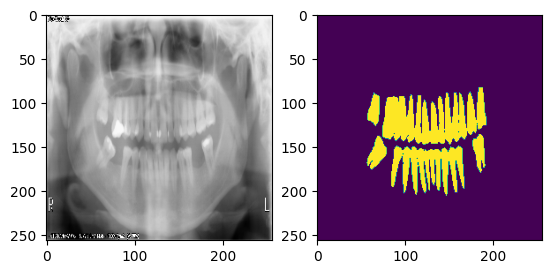

In [ ]:
x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 1

In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
     smooth = 1.
     y_true_f = K.flatten(y_true)
     y_pred_f = K.flatten(y_pred)
     intersection = K.sum(y_true_f * y_pred_f)
     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
     return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
!pip install focal_loss

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from focal_loss import BinaryFocalLoss
'''
Here an implementation of the unnet model
This takes input that are already normalized.

Unet in few words:
- A contraction path
- A expansive path
- Skip-connections (concating means adding volume)
'''

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=['accuracy',dice_coef])
    model.summary()

    return model


In [ ]:
model = simple_unet_model(IMG_HEIGHT,IMG_WIDTH,CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),checkpointer ]

In [ ]:
# Define the combined generator function
def combined_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)

# Create the combined generators
train_generator = combined_generator(image_generator, mask_generator)
val_generator = combined_generator(valid_img_generator, valid_mask_generator)


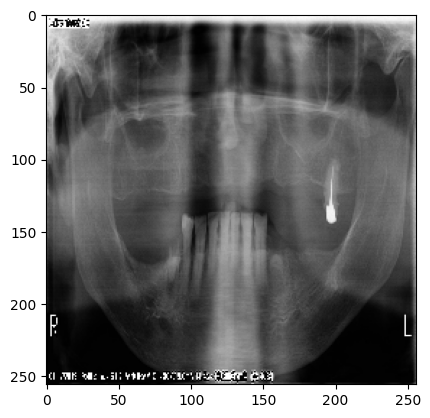

In [ ]:
img,mask = next(train_generator)
plt.imshow(img[2],cmap = "gray")


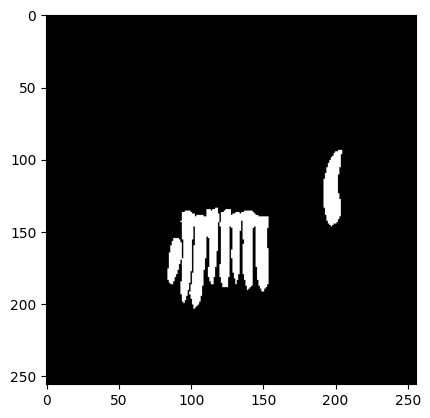

In [ ]:
plt.imshow(mask[2],cmap = "gray")

In [ ]:
num_train_imgs = len(os.listdir('/content/data/train_images/img'))

steps_per_epoch = num_train_imgs //batch_size

history = model.fit(train_generator, validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=50,verbose= 1)

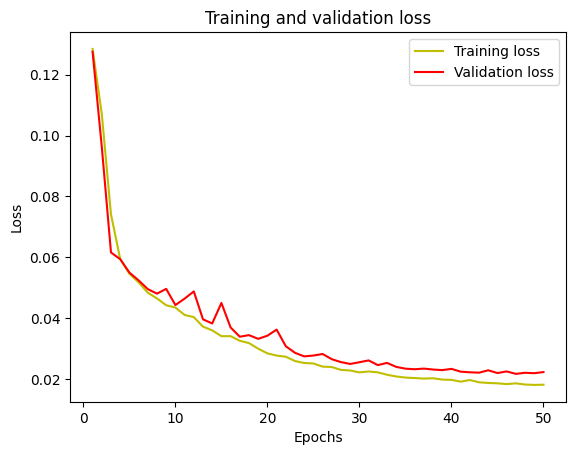

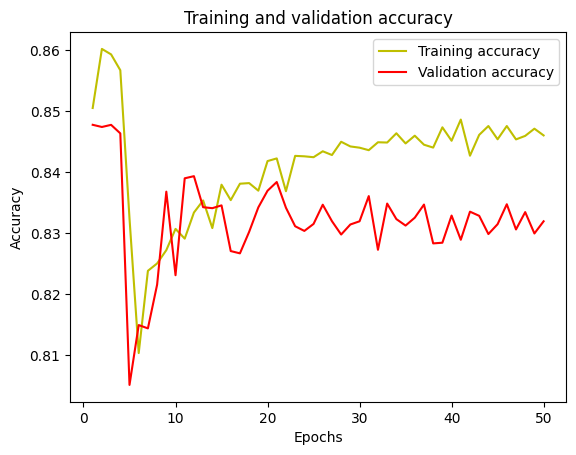

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_img_generator = image_data_generator.flow_from_directory("data/test_images/",
                                                              seed=seed,
                                                              target_size=(256, 256),
                                                              batch_size=32,
                                                              color_mode = 'grayscale',
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("data/test_masks/",
                                                              seed=seed,
                                                              target_size=(256, 256),
                                                              batch_size=32,
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here


Found 61 images belonging to 1 classes.
Found 61 images belonging to 1 classes.


1/1 [==============================] - 1s 1s/step


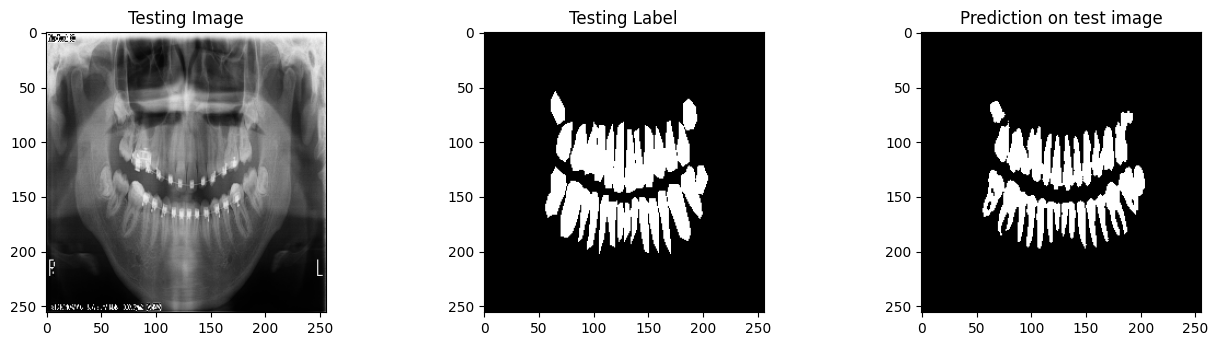

In [ ]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()



In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

In [ ]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)


Mean IoU is:  [0.4288392]
